## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [26]:
# from __future__ import print_function 
import argparse
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple

from guided_diffusion import logger, deca_dpm

from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_deca_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [27]:
def create_argparser(log_dir, img_model_path, deca_model_path, image_size, in_ch, out_ch, **kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=15,
        use_ddim=False,
        img_model_path=img_model_path,
        deca_model_path=deca_model_path,
        log_dir=log_dir,
        diffusion_step=1000,
        timestep_respacing=1000,
        image_size=image_size,
        in_image="raw"
    )

    defaults.update(model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch))
    return namedtuple('GenericDict', defaults.keys())(**defaults)

def model_and_diffusion_defaults(image_size, in_ch, out_ch):
    """
    Defaults for image training.
    """
    res = dict(
        image_size=image_size,
        num_channels=128,
        in_channels=in_ch,
        out_channels=out_ch,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        z_cond=False,
    )
    res.update(diffusion_defaults())
    return res

In [28]:
# List model_logs
ct = "v7"
sshfs_path = "/home/mint/mnt_tl_puntawat-ms-7c37"
# sshfs_path = ""
model_logs_path = f"{sshfs_path}/home/puntawat/Mint/Work/Vision/Diffusion/mount/{ct}/"
print(os.listdir(model_logs_path))

# args
log_dir = "DECA_128_raw"

step = "200000"
ckpt = f"model{step}"
# ckpt = f"ema_0.9999_{step}"
# model_logs_path = "/home2/mint/model_logs_mount/v8_model_logs/"
img_model_path = f"{model_logs_path}/{log_dir}/img_{ckpt}.pt"
deca_model_path = f"{model_logs_path}/{log_dir}/DECA_{ckpt}.pt"

image_size=128
in_ch = 3
out_ch = 3
args = create_argparser(log_dir=log_dir, img_model_path=img_model_path, deca_model_path=deca_model_path, image_size=image_size, in_ch=in_ch, out_ch=out_ch)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))


# dist_util.setup_dist()
# logger.configure()

if args.in_image in ['raw', 'raw+uvdn']:
    model_and_diffusion = model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch)
    print("creating {} model and diffusion...".format(args.in_image))
else:
    raise NotImplementedError


# for k, v in model_and_diffusion.items():
    # print(k, v)

img_model, deca_model, diffusion = create_deca_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)


img_model.load_state_dict(
    th.load(args.img_model_path, map_location="cpu")
)

deca_model.load_state_dict(
    th.load(args.deca_model_path, map_location="cpu")
)

img_model.to('cuda')
deca_model.to('cuda')
img_model.eval()
deca_model.eval()



['flower_1k_hsv_100k', 'flower_1k_rbg', 'flower_1k_hls_100k', 'DECA_128_raw', 'flower_1k_hsv', 'flower_1k_rbg_100k', 'flower_1k_hls', 'flower_1k_ycrcb_100k', 'flower_1k_ycrcb']
creating raw model and diffusion...


DECADense(
  (activation): LeakyReLU(negative_slope=0.01)
  (emb_layers): Sequential(
    (0): SiLU()
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_mlp): ModuleList(
    (0): Linear(in_features=159, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (mid_mlp): Sequential(
    (0): Linear(in_features=33280, out_features=512, bias=True)
  )
  (output_mlp): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=159, bias=True)
  )
)

In [85]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_

def plot_sample(img, **kwargs):
    columns = 6
    rows = 10
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()
        

  0%|          | 0/1000 [00:00<?, ?it/s]

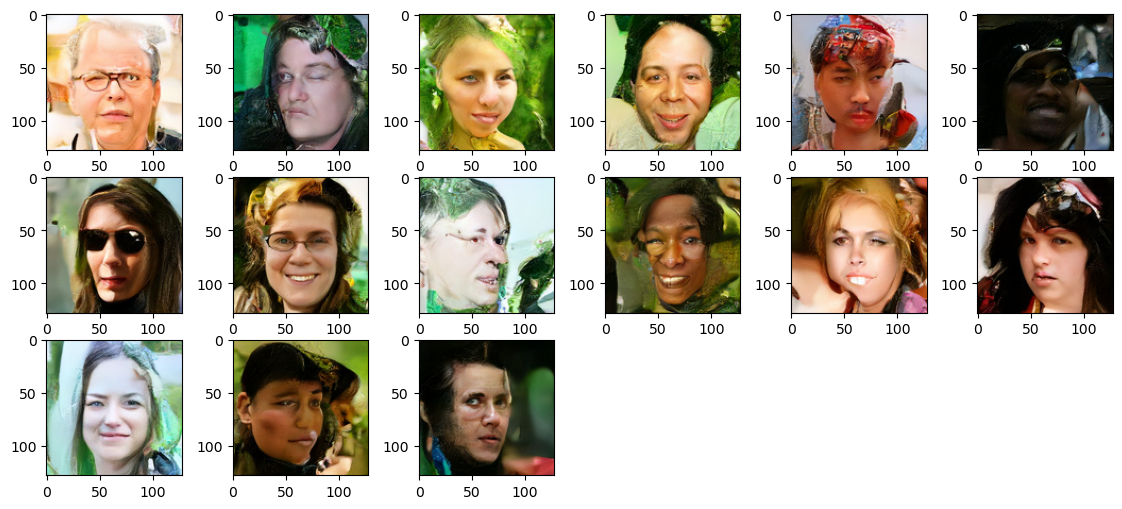

In [30]:
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, img_model, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model=img_model
        self.deca_model=deca_model
        self.sample_fn = sample_fn
        self.deca_dpm = deca_dpm.Diffusion_DECA(img_model=self.img_model, deca_model=self.deca_model, diffusion=diffusion, progress=True)

    def forward(self):
        seed_all(33)
        if self.sample_fn == 'p_sample_loop':
            img_output, deca_output = self.deca_dpm.p_sample_loop(
                                        shape_dict={'img':(args.batch_size, in_ch, args.image_size, args.image_size),
                                                    'deca':(args.batch_size, 159)})

        return {"img_output":img_output, "deca_output":deca_output}

pl_inference = PLInference(img_model=img_model, deca_model=deca_model, sample_fn='p_sample_loop')
sample = pl_inference()
plot_sample(sample["img_output"])


In [31]:
# import pytorch_lightning as pl
# class PLInference(pl.LightningModule):
#     def __init__(self, img_model, deca_model, sample_fn):
#         super(PLInference, self).__init__()
#         self.img_model=img_model
#         self.deca_model=deca_model
#         self.sample_fn = sample_fn

#     def forward(self):
#         seed_all(33)
#         sample = self.sample_fn(
#             model=self.img_model,
#             shape=(args.batch_size, in_ch, args.image_size, args.image_size),
#             clip_denoised=args.clip_denoised,
#         )
#         return sample

# pl_inference = PLInference(img_model=img_model, deca_model=deca_model, sample_fn=diffusion.p_sample_loop)
# sample = pl_inference()
# plot(sample)

In [79]:
from ast import Expression, arg, parse
from pickle import PickleError
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn.functional as F
import glob, os
import PIL
import matplotlib.pyplot as plt
from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from collections import defaultdict
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
import model_3d.FLAME.utils.detectors as detectors
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale


def params_to_model(shape, exp, pose, cam, i, uvdn=None):
    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)

    renderer = SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    opdict = {'verts' : verts,}

    save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    # img_uvdn = th.unsqueeze(th.tensor(params['uv_detail_normals']).permute((2, 0, 1)), dim=0).cuda().to(flame.dtype)

    # detail_normal_images = F.grid_sample(img_uvdn, ops['grid'], align_corners=False)*ops['alpha_images']
    # shape_detail_images = renderer.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)

#     plt.imshow(np.concatenate((shape_images[0].detach().cpu().numpy().transpose([1, 2, 0]), 
#             ops['images'][0].detach().cpu().numpy().transpose([1, 2, 0]),
#             shape_detail_images[0].detach().cpu().numpy().transpose([1, 2, 0])
#             ), axis=1))
#     plt.show()
    return {"shape_images":shape_images}

def save_obj(renderer, filename, opdict):
    '''
    vertices: [nv, 3], tensor
    texture: [3, h, w], tensor
    '''
    i = 0
    vertices = opdict['verts'][i].cpu().numpy()
    faces = renderer.faces[0].cpu().numpy()
    colors = np.ones(shape=vertices.shape) * 127.5

    # save coarse mesh, with texture and normal map
    # normal_map = util.tensor2image(opdict['uv_detail_normals'][i]*0.5 + 0.5)
    util.write_obj(filename, vertices, faces, colors=colors)


flame = FLAME.FLAME(flame_cfg.model).cuda()
sample['deca_output']

img_ = []
import tqdm
for i in tqdm.tqdm(range(sample['deca_output'].shape[0])):
    deca_params = sample['deca_output'][i]
    shape = deca_params[None, :100]
    pose = deca_params[None, 100:106]
    exp = deca_params[None, 106:156]
    cam = deca_params[None, 156:]
    print(shape.shape, type(shape), shape.device, shape.dtype)
    print(pose.shape, type(pose), pose.device, pose.dtype)
    print(exp.shape, type(exp), exp.device, exp.dtype)
    print(cam.shape, type(cam), cam.device, cam.dtype)
    img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
    print(img["shape_images"].shape)
    assert False
    img_.append(img["shape_images"])

plot_sample(th.cat(img_, dim=0))




creating the FLAME Decoder


  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([1, 100]) <class 'torch.Tensor'> cuda:0 torch.float32
torch.Size([1, 6]) <class 'torch.Tensor'> cuda:0 torch.float32
torch.Size([1, 50]) <class 'torch.Tensor'> cuda:0 torch.float32
torch.Size([1, 3]) <class 'torch.Tensor'> cuda:0 torch.float32


  0%|          | 0/15 [00:01<?, ?it/s]

torch.Size([1, 3, 256, 256])


AssertionError: 

# Analysis of Face params

In [69]:
# Test params_to_model fn
def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s


params_key = ['shape', 'pose', 'exp', 'cam']
anno_path = glob.glob(f'/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/*.txt')
params = {}
for k in params_key:
    for p in anno_path:
        # Params
        if k in p:
            print(f'Key=> {k} : Filename=>{p}')
            params[k] = read_params(path=p)

params_s = swap_key(params)

img_dataset_path = '/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/ffhq_256/train/'

Key=> shape : Filename=>/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/ffhq-train-cam-anno.txt


torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 256, 256])


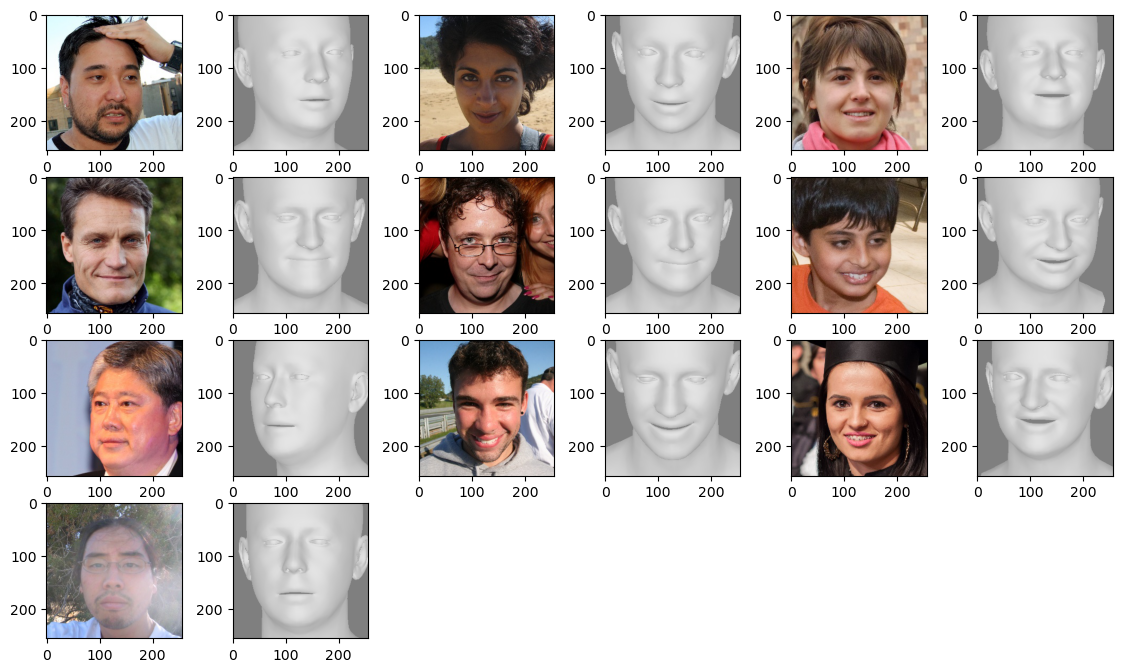

In [97]:
img_name_list = [str(n) + '.jpg' for n in list(np.random.randint(0, 60000, 10))]

render_img_list = []
src_img_list = []
img_list = []
for img_name in img_name_list:
    shape = th.tensor(params_s[img_name]['shape'][None, :]).float().cuda()
    pose = th.tensor(params_s[img_name]['pose'][None, :]).float().cuda()
    exp = th.tensor(params_s[img_name]['exp'][None, :]).float().cuda()
    cam = th.tensor(params_s[img_name]['cam'][None, :]).float().cuda()

    src_img = PIL.Image.open(img_dataset_path + img_name)
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

    render_img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=img_name)
    render_img_list.append(render_img["shape_images"])

src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
print(src_img.shape, render_img.shape)
plot_sample(img=src_img, render_img=render_img)